In [146]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def ave_logloss(y,yp):
    yp = np.min(np.max(yp,1e-5),1-1e-5)
    return np.mean(-(y*np.log(yp)+(1-y)*np.log(1-yp)))

from sklearn.metrics import auc,roc_curve
def myauc(yr,yp):
    score=[]
    for i in range(yr.shape[1]):
        y, pred = yr[:,i], yp[:,i]
        fpr, tpr, thresholds = roc_curve(y, pred, pos_label=1)
        score.append(auc(fpr, tpr))
    return score
    

In [3]:
X = pd.read_csv('./data/panCancer_SGA_mat.csv')
Y = pd.read_csv('./data/panCancer_DEG_mat.csv')

In [4]:
print X.shape, Y.shape

(4443, 1702) (4443, 570)


In [5]:
X = X.drop(['tumor_id','cancer_type'],axis=1).values
Y = Y.drop(['tumor_id','cancer_type'],axis = 1).values
print X.shape,Y.shape,X.max(),X.min(),Y.max(),Y.min()

(4443, 1700) (4443, 568) 1 0 1 -1


In [6]:
#M = X.shape[0]
N = X.shape[1]
C = Y.shape[1]
learning_rate = 0.05
lambdax = 0.3
H1 = 80
#H2 = 30

In [106]:
def dropout(x, keep_prob, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(x, keep_prob), lambda: x)
def build_nn(keepprob, kp2):
    tf.reset_default_graph()
    with tf.name_scope('bi_clf'):
        x = tf.placeholder('float32',shape=[None,N],name='x') # M samples, N features
        y = tf.placeholder('float32',shape=[None,C],name='y') # M samples, C classes
        is_training = tf.placeholder(tf.bool)
        
        with tf.variable_scope('weights'):
            w0 = tf.get_variable(name='w0',shape=[N,H1])
            w1 = tf.get_variable(name='w1',shape=[H1,C])
            #w2 = tf.get_variable(name='w2',shape=[H2,C])
            w_0 = tf.summary.histogram("logs/weights_0", w0)
            w_1 = tf.summary.histogram("logs/weights_1", w1)
        xtmp = dropout(x, keep_prob=keepprob, is_training = is_training)
        yp = tf.nn.sigmoid(tf.matmul(xtmp,w0))
        #yp = dropout(yp, keep_prob=keepprob, is_training = is_training)
        yp = tf.nn.sigmoid(tf.matmul(yp,w1))
        #yp = tf.nn.sigmoid(tf.matmul(yp,w2))
    
        xtmp2 = dropout(x, keep_prob=kp2, is_training = is_training)
        yp2 = tf.nn.sigmoid(tf.matmul(xtmp2,w0))
        yp2 = tf.nn.sigmoid(tf.matmul(yp2,w1))
        
        with tf.name_scope('loss'):
            yp = tf.maximum(yp,1e-5)
            yp = tf.minimum(yp,1-1e-5)
            loss = -(y*tf.log(yp)+(1-y)*tf.log(1-yp))
            l2loss = lambdax*(tf.reduce_mean(w0*w0)+tf.reduce_mean(w1*w1))
            loss = tf.reduce_mean(loss) + l2loss
        merged = tf.summary.merge_all()
        optimizer = tf.train.AdamOptimizer(learning_rate)
        opt_op = optimizer.minimize(loss)
        rw0 = w0 + 0
    return x, y, yp, opt_op, is_training, rw0, xtmp2, yp2,merged

In [107]:
def get_fea_importance(y,yp,xm):
    auc = np.array(myauc(y,yp))
    mask = np.any(xm,axis=0)
    importance = np.zeros((xm.shape[1],yp.shape[1]))
    #print mask.shape,importance.shape,auc.shape
    importance[mask,:] += auc
    return auc,importance
def run_one_fold_feature_importance(Xtr,ytr,Xva,yva,foldid,epochs,x,y,yp,Xmask,sess,is_training):
    EPOCHS = epochs
    imp = []
    if True:
        for i in range(EPOCHS):
            # Training
            pred, xm = sess.run([yp,Xmask],feed_dict={x:Xva,y:yva,is_training:True})
            auc,importance = get_fea_importance(yva,pred,xm)
            imp.append(importance)
            if i%50==0:
                print "Fold %d Epoch %d Feature Selection AUC %f"%(foldid,i,np.mean(auc))
    return np.mean(np.array(imp),axis=0)

In [108]:
def run_one_fold(Xtr,ytr,Xva,yva,foldid,keepprob, kp2, epochs,feature_selection=False):
    EPOCHS = epochs
    x,y,yp, opt_op, is_training, rw0, Xmask, yp2,merged = build_nn(keepprob, kp2)
    imp = []
    aucs=[]
    with tf.Session() as sess:
        #sess.run(tf.initialize_all_variables())
        sess.run(tf.global_variables_initializer())
        summary_writer = tf.summary.FileWriter('logs', sess.graph)
        for i in range(EPOCHS):
            # Training
            pred,_ = sess.run([yp,opt_op],feed_dict={x:Xtr,y:ytr,is_training:True})
            tr_loss = ave_logloss(ytr, pred)
            # Testing
            if True:
                summary, pred, prw0 = sess.run([merged,yp, rw0],feed_dict={x:Xva,y:yva,is_training:False})
                summary_writer.add_summary(summary, i)
                va_loss = ave_logloss(yva, pred)
                va_auc = myauc(yva, pred)
                aucs.append(va_auc)
            if i%50==0:
                print "Fold %d Epoch %d Train Logloss %f Val LogLoss %f Val AUC %f"%(foldid,i,tr_loss,va_loss, np.mean(va_auc))
        if feature_selection:
            imp = run_one_fold_feature_importance(Xtr,ytr,Xva,yva,foldid,epochs,x,y,yp2,Xmask,sess,is_training)
                
    return va_loss, aucs, prw0,imp   

In [109]:
a=np.array([[0,0,0],[1,1,1]])
print np.any(a,axis=1), np.any(a,axis=0)

[False  True] [ True  True  True]


In [110]:
from sklearn.model_selection import KFold, StratifiedKFold
def cv(X, y, num_folds=4, keepprob=1.0, kp2=0.1, epochs=100, feature_selection=False):
    logloss,aucs,rw0s = [],[],[]
    kf = KFold(n_splits=num_folds,shuffle=True,random_state=42)
    imps = []
    for k, (tr, te) in enumerate(kf.split(X)):
        Xtr, Xva = X[tr], X[te]
        ytr, yva = y[tr], y[te]
        print Xtr.shape, Xva.shape, ytr.shape, yva.shape
        l,a,rw0,imp = run_one_fold(Xtr,ytr,Xva,yva,foldid=k,keepprob=keepprob, kp2=kp2, epochs=epochs, feature_selection=feature_selection)
        logloss.append(l)
        aucs.append(a)
        rw0s.append(rw0)
        imps.append(imp)
        break
    print "Average LogLoss %f AUC %f "%(np.mean(logloss),np.mean(aucs[-1]))
    return logloss, aucs, rw0s,np.mean(np.array(imps),axis=0)

In [111]:
logloss,aucs,rw0s,imps = cv(X,np.abs(Y), 4, keepprob=0.7, kp2=0.1,feature_selection=False,epochs=50) # with dropout 0.7

(3332, 1700) (1111, 1700) (3332, 568) (1111, 568)
Fold 0 Epoch 0 Train Logloss 0.474932 Val LogLoss 0.513714 Val AUC 0.568195
Average LogLoss 0.690338 AUC 0.689158 


In [112]:
aucs=np.array(aucs)
print aucs.shape

(1, 50, 568)


#keep 0.05 features will select appropriate number of features

In [113]:
logloss,aucs,rw0s,imps = cv(X,np.abs(Y), 4, keepprob=0.5,kp2=0.05,epochs=200,feature_selection=False)

(3332, 1700) (1111, 1700) (3332, 568) (1111, 568)
Fold 0 Epoch 0 Train Logloss 0.479854 Val LogLoss 0.476919 Val AUC 0.559553
Fold 0 Epoch 50 Train Logloss 0.683739 Val LogLoss 0.722004 Val AUC 0.751878
Fold 0 Epoch 100 Train Logloss 0.616238 Val LogLoss 0.674267 Val AUC 0.789257
Fold 0 Epoch 150 Train Logloss 0.645346 Val LogLoss 0.698502 Val AUC 0.796217
Average LogLoss 0.710938 AUC 0.761791 


In [115]:
#aucs=aucs[0]
aucs = np.array(aucs)
print aucs.shape

(200, 568)


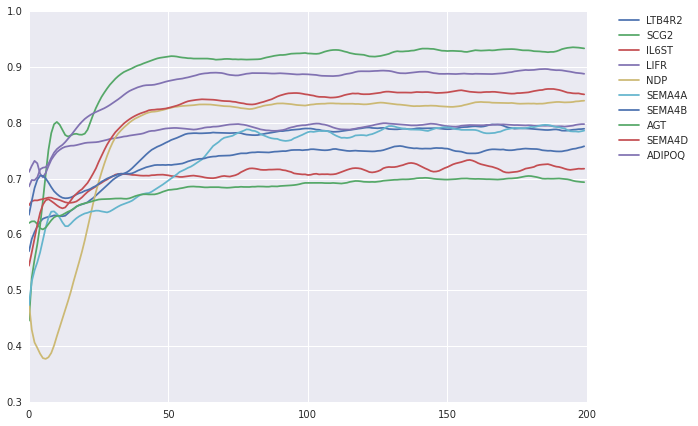

In [132]:
with open('./data/panCancer_SGA_mat.csv','r') as f:
    header = f.readline().strip().split(',')
with open('./data/panCancer_DEG_mat.csv','r') as f:
    classes = f.readline().strip().split(',')
header = header[2:]
classes = classes[2:]
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
for i in range(10):
    plt.plot(aucs[:,i],label=classes[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [138]:
tmp = pd.read_csv('data/heatmap1.txt')
tmp.head()

,feature,class,importance
0,RNF14,HBEGF,0.093365
1,RNF14,BMP5,0.095805
2,RNF14,IL2RG,0.088028
3,RNF14,UCN2,0.104675
4,RNF14,RARA,0.095277


In [160]:
import csv
from random import randint
def write(inputfile,features,classes,output):
    dic = {}
    with open(inputfile,'r') as f:
        for c,row in enumerate(csv.DictReader(f)):
            if row['feature'] not in features:
                continue
            if row['feature'] not in dic:
                dic[row['feature']] = {}
            for i in classes:
                dic[row['feature']][i]=row[i]
    with open(output,'w') as fo:
        head = "feature,class,importance\n"
        fo.write(head)
        for i in dic:
            for j in classes:
                fo.write('%s,%s,%s\n'%(i,j,dic[i][j]))

with open('./data/panCancer_SGA_mat.csv','r') as f:
    header = f.readline().strip().split(',')
with open('./data/panCancer_DEG_mat.csv','r') as f:
    classes = f.readline().strip().split(',')

header,classes = np.array(header),np.array(classes)
xx = np.random.randint(0,500,10).tolist()
print xx
header = ['APC','TP53']+header[xx].tolist()
classes = classes[xx]
write(inputfile='data/feature_importance_cv_auc_0.795_select_0.05.csv',features=header,classes=classes,output='data/heatmap1.txt')

[413, 103, 57, 472, 153, 262, 458, 347, 462, 62]


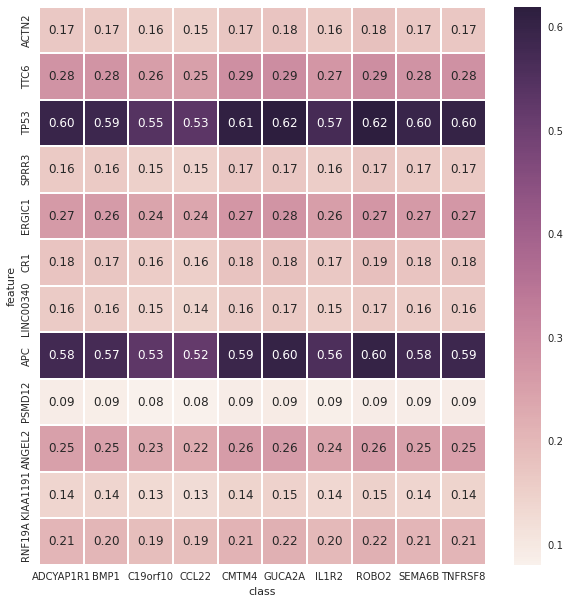

In [161]:
sns.set()

# Load the example flights dataset and conver to long-form
df = pd.read_csv('data/heatmap1.txt')
df=df.drop_duplicates(subset=["feature", "class", "importance"])
df["feature"] = pd.Categorical(df["feature"], df.feature.unique())
#feature,class,importance
flights = df.pivot("feature", "class", "importance")

# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(10,10))
sns.heatmap(flights, annot=True, fmt=".2f", linewidths=.5)

#keep 0.5 will select too many features